In [87]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

#### Load resume CSVs into DataFrames

In [3]:
# path to cleaned resume file
resume_cleaned_path = '/Users/richardkuzma/coding/NLP_projects/job_recommender_project/data/cleaned_resume_dataset_maitrip.csv'

# load cleaned jobs to df
resumes = pd.read_csv(resume_cleaned_path)
resumes.head()

,ID,Category,dirty_resume,resume
0,1,HR,"b'John H. Smith, P.H.R.\n800-991-5187 | PO Box...",john h smith phr po box callahan fl infog...
1,2,HR,b'Name Surname\nAddress\nMobile No/Email\nPERS...,name surname address mobile noemail personal p...
2,3,HR,b'Anthony Brown\nHR Assistant\nAREAS OF EXPERT...,anthony brown hr assistant areas expertise per...
3,4,HR,b'www.downloadmela.com\nSatheesh\nEMAIL ID:\nC...,satheesh email id career objective pursue gro...
4,5,HR,"b""HUMAN RESOURCES DIRECTOR\n\xef\x82\xb7Expert...",human resources director expert organizational...


In [4]:
# path to cleaned jobs file
jobs_cleaned_path = '/Users/richardkuzma/coding/NLP_projects/job_recommender_project/data/cleaned_job_posts_madhab.csv'

#load cleaned jobs to df
jobs = pd.read_csv(jobs_cleaned_path)
jobs.head()

,Title,Company,JobDescription,RequiredQual,JobRequirement,label,combined,dirty_combined
0,Chief Financial Officer,AMERIA Investment Consulting Company,AMERIA Investment Consulting Company is seekin...,"To perform this job successfully, an\r\nindivi...",- Supervises financial management and administ...,1,chief financial officer ameria investment cons...,Chief Financial Officer AMERIA Investment Cons...
1,Country Coordinator,Caucasus Environmental NGO Network (CENN),Public outreach and strengthening of a growing...,"- Degree in environmentally related field, or ...",- Working with the Country Director to provide...,2,country coordinator public outreach strengthen...,Country Coordinator Public outreach and streng...
2,BCC Specialist,Manoff Group,The LEAD (Local Enhancement and Development fo...,"- Advanced degree in public health, social sci...",- Identify gaps in knowledge and overseeing in...,3,bcc specialist lead local enhancement developm...,BCC Specialist The LEAD (Local Enhancement and...
3,"Community Development, Capacity Building and C...",Food Security Regional Cooperation and Stabili...,Food Security Regional Cooperation and Stabili...,- Higher Education and/or professional experie...,- Assist the Tavush Marz communities and commu...,4,community development capacity building confli...,"Community Development, Capacity Building and C..."
4,Country Economist (NOB),"United Nations Development Programme, Armenia",The United Nations Development Programme in Ar...,- Minimum Masters Degree in Economics;\r\n- Mi...,The incumbent under direct supervision of UNDP...,5,country economist nob united nations developme...,Country Economist (NOB) The United Nations Dev...


<br><br><br><br><br>

# Gensim Doc2Vec on Jobs

#### What is Doc2Vec?
- Unsupervised learning algorithm
- Generate vector representations for sentences, paragraphs, or documents. In our case, one vector per resume. 
- Builds on Word2Vec, which represents an individual word with a vector
- Doc2Vec vectors are word-order independent. 'The cat sat on the mat' is no different than 'mat sat the on cat'
    - contextualized word embeddings are tougher and more computationally expensive to do and perform better on tasks like word prediction

#### Read more:
-  Distributed Representations of Sentences and Documents https://arxiv.org/abs/1405.4053

#### Thank you gensim
- This is heavily based/built on the gensim implementation of Doc2Vec
    - https://radimrehurek.com/gensim/models/doc2vec.html
    - https://praveenbezawada.com/2018/01/25/document-similarity-using-gensim-dec2vec/

In [9]:
# TaggedDocumentIterator class takes pandas text and label Series and yields TaggedDocuments

class TaggedDocumentIterator(object):
    def __init__(self, doc_list, labels_list):
        self.labels_list = labels_list
        self.doc_list = doc_list
    def __iter__(self):
        for idx, doc in enumerate(self.doc_list):
            yield TaggedDocument(words=doc.split(), tags=[self.labels_list[idx]])
 
docLabels = list(jobs['label'])
jobs_data = list(jobs['combined'])
jobs_sentences = TaggedDocumentIterator(jobs_data, docLabels)

### Paragraph Vector - Distributed Memory Model

In [69]:
# train Doc2Vec model on jobs

d2v_jobs_model_dm = Doc2Vec(vector_size=100,
                               window=5,
                               min_count=20,
                               workers=4,
                               alpha=0.025,
                               min_alpha=0.0025,
                               epochs=100,
                               dm=1, #paragraph vector - distributed memory
                               seed=42)
d2v_jobs_model_dm.build_vocab(jobs_sentences)
d2v_jobs_model_dm.train(jobs_sentences,
                     total_examples=d2v_jobs_model_dm.corpus_count,
                     epochs=d2v_jobs_model_dm.epochs)


#save and re-load
d2v_jobs_model_dm_path = '/Users/richardkuzma/coding/NLP_projects/job_recommender_project/models/d2v/dm_jobs_100.doc2vec'
d2v_jobs_model_dm.save(d2v_jobs_model_dm_path)



### Paragraph Vector - Distributed Bag of Words Model

In [61]:
d2v_jobs_model_dbow = Doc2Vec(vector_size=100,
                               window=10,
                               min_count=20, #avoid words that appear fewer than 20 times
                               workers=11,
                               alpha=0.025,
                               #min_alpha=0.0025,
                               epochs=20,
                               dm=0, #paragraph vector - distributed bag of words
                               seed=42)
d2v_jobs_model_dbow.build_vocab(jobs_sentences)
d2v_jobs_model_dbow.train(jobs_sentences,
                     total_examples=d2v_jobs_model_dbow.corpus_count,
                     epochs=d2v_jobs_model_dbow.epochs)


#save and re-load
d2v_jobs_model_dbow_path = '/Users/richardkuzma/coding/NLP_projects/job_recommender_project/models/d2v/dbow_jobs_20_epochs.doc2vec'
d2v_jobs_model_dbow.save(d2v_jobs_model_dbow_path)

## Given a resume number, predict jobs
- Embeds one chosen resume as a vector, compares similarity to all jobs to determine most similar

In [52]:
def given_resume_predict_jobs(d2v_jobs_model, job_chosen=-999):
    print("There are {} resumes\n".format(resumes.shape[0]))
    selection = 0
    
    # Select a random int from 0 to length of resume set
    
    if resume_chosen >=0 and resume_chosen <resumes.shape[0]:
        selection = resume_chosen
        print('You selected resume ID #{}\n'.format(selection))
    else:
        #default to random selection
        selection = np.random.randint(1, resumes.shape[0]+1)
        print ('Random selected resume is ID #{}\n'.format(selection))
        
    
    print('selection is {}'.format(selection))
    pick_text = resumes.iloc[selection -1 ]['resume'][0:2000]
    pick_label = resumes.iloc[selection -1, resumes.columns.get_loc('ID')] #we could grab ID, but this works for non-indexed labels too
    print('Resume ID is: {}'.format(pick_label))
    print('Resume text: {}'.format(pick_text))

    #Convert the sample document into a list and use the infer_vector method to get a vector representation for it
    pick_words = pick_text.split()
    pick_vec = d2v_jobs_model.infer_vector(pick_words, epochs=50, alpha=0.25)
 
    #use the most_similar utility to find the most similar documents.
    similars = d2v_jobs_model.docvecs.most_similar(positive=[pick_vec])
 
    print('\n\n\n\n\t\t\t\tSimilar job descriptions to this resume:')
    
    count = 1
    for i in similars:
        print('\n\n\nSimilar job number: {}'.format(count))
        count += 1
        print('Job ID ', i[0], ' Similarity Score: ', i[1])
        
        # pulls combined text from jobs_train 
        #print(jobs_train.iloc[i[0]]['combined'],  '\n')

        # pulls job title and description from jobs.txt
        print('Job title: {}'.format(jobs.iloc[i[0]]['Title']))
        print('Company: {}'.format(jobs.iloc[i[0]]['Company']))
        print('Description: {}'.format(jobs.iloc[i[0]]['JobDescription']))
        
        


#### Select your model(s) to use

In [62]:
dm_jobs_20 = Doc2Vec.load('/Users/richardkuzma/coding/NLP_projects/job_recommender_project/models/d2v/dm_jobs_20_epochs.doc2vec')
dm_jobs_50 = Doc2Vec.load('/Users/richardkuzma/coding/NLP_projects/job_recommender_project/models/d2v/dm_jobs_50_epochs.doc2vec')
dm_jobs_100 = Doc2Vec.load('/Users/richardkuzma/coding/NLP_projects/job_recommender_project/models/d2v/dm_jobs_100_epochs.doc2vec')


dbow_jobs_20 = Doc2Vec.load('/Users/richardkuzma/coding/NLP_projects/job_recommender_project/models/d2v/dbow_jobs_20_epochs.doc2vec')
dbow_jobs_50 = Doc2Vec.load('/Users/richardkuzma/coding/NLP_projects/job_recommender_project/models/d2v/dbow_jobs_50_epochs.doc2vec')
dbow_jobs_100 = Doc2Vec.load('/Users/richardkuzma/coding/NLP_projects/job_recommender_project/models/d2v/dbow_jobs_100_epochs.doc2vec')




In [63]:
# 20 epochs dbow
given_resume_predict_jobs(dbow_jobs_20, 192)
#192


There are 1219 resumes

You selected resume ID #192

selection is 192
Resume ID is: 192
Resume text: professional summary around  years experience java technologies excellent java development skills using jee jse servlets jsp ejb jdbc sockets jfcswing java beans applets hands experience handling use cases functional specification knowledge transfers business analysis extensive object oriented development oopood experience good working knowledge application development maintenance life cycle process professional experience currently working software engineer xxx technologies bangalore july  working software engineer xxx software pvt ltd bangalore may  june  scholastic profile university madras  aggregate   standard higher secondary education board  aggregate  th standard secondary education board  aggregate  achievements achieved sun certification java platform certified scrum master scrum alliance technical expertise operating system windows nt xp linux solaris primary skills jsp hiber

In [55]:
#distributed memory model 20 epochs
given_resume_predict_jobs(dm_jobs_20, 192)

There are 1219 resumes

You selected resume ID #192

selection is 192
Resume ID is: 192
Resume text: professional summary around  years experience java technologies excellent java development skills using jee jse servlets jsp ejb jdbc sockets jfcswing java beans applets hands experience handling use cases functional specification knowledge transfers business analysis extensive object oriented development oopood experience good working knowledge application development maintenance life cycle process professional experience currently working software engineer xxx technologies bangalore july  working software engineer xxx software pvt ltd bangalore may  june  scholastic profile university madras  aggregate   standard higher secondary education board  aggregate  th standard secondary education board  aggregate  achievements achieved sun certification java platform certified scrum master scrum alliance technical expertise operating system windows nt xp linux solaris primary skills jsp hiber

In [59]:
# 50 epochs dbow
given_resume_predict_jobs(dbow_jobs_50, 192)

There are 1219 resumes

You selected resume ID #192

selection is 192
Resume ID is: 192
Resume text: professional summary around  years experience java technologies excellent java development skills using jee jse servlets jsp ejb jdbc sockets jfcswing java beans applets hands experience handling use cases functional specification knowledge transfers business analysis extensive object oriented development oopood experience good working knowledge application development maintenance life cycle process professional experience currently working software engineer xxx technologies bangalore july  working software engineer xxx software pvt ltd bangalore may  june  scholastic profile university madras  aggregate   standard higher secondary education board  aggregate  th standard secondary education board  aggregate  achievements achieved sun certification java platform certified scrum master scrum alliance technical expertise operating system windows nt xp linux solaris primary skills jsp hiber

In [60]:
# 100 epochs dbow
given_resume_predict_jobs(dbow_jobs_100, 192)

There are 1219 resumes

You selected resume ID #192

selection is 192
Resume ID is: 192
Resume text: professional summary around  years experience java technologies excellent java development skills using jee jse servlets jsp ejb jdbc sockets jfcswing java beans applets hands experience handling use cases functional specification knowledge transfers business analysis extensive object oriented development oopood experience good working knowledge application development maintenance life cycle process professional experience currently working software engineer xxx technologies bangalore july  working software engineer xxx software pvt ltd bangalore may  june  scholastic profile university madras  aggregate   standard higher secondary education board  aggregate  th standard secondary education board  aggregate  achievements achieved sun certification java platform certified scrum master scrum alliance technical expertise operating system windows nt xp linux solaris primary skills jsp hiber

# Resume embeddings:

In [113]:
# # TaggedDocumentIterator class takes pandas text and label Series and yields TaggedDocuments
# class TaggedDocumentIterator(object):
#     def __init__(self, doc_list, labels_list):
#         self.labels_list = labels_list
#         self.doc_list = doc_list
#     def __iter__(self):
#         for idx, doc in enumerate(self.doc_list):
#             yield TaggedDocument(words=doc.split(), tags=[self.labels_list[idx]])
 


In [34]:
# make TaggedDocuments from resumes dataframe to then create d2v model
resumes_labels = list(resumes['ID'].astype(str))
resumes_data = list(resumes['resume'].astype(str))
resumes_sentences = TaggedDocumentIterator(resumes_data, resumes_labels)

## D2V distributed memory resumes model

In [66]:
# train Doc2Vec model on jobs

d2v_resume_model_dm = Doc2Vec(vector_size=100,
                           window=10,
                           min_count=20,
                           dm=1, #distributed memory
                           workers=4,
                           alpha=0.025,
                           #min_alpha=0.0025,
                           epochs=100)
d2v_resume_model_dm.build_vocab(resumes_sentences)
d2v_resume_model_dm.train(resumes_sentences,
                             total_examples=d2v_resume_model_dm_20.corpus_count, 
                             epochs=d2v_resume_model_dm_20.epochs)

# Store the d2v jbos model to file
d2v_resume_model_path = '/Users/richardkuzma/coding/NLP_projects/job_recommender_project/models/d2v/dm_resumes_100.doc2vec'

#save and load the model
d2v_resume_model_dm.save(d2v_resume_model_path)


## D2V DBOW Resumes Model

In [68]:
# train Doc2Vec model on jobs

d2v_resume_model_dbow = Doc2Vec(vector_size=100,
                           window=10,
                           min_count=20,
                           dm=0, #dbow
                           workers=4,
                           alpha=0.025,
                           #min_alpha=0.0025,
                           epochs=100)
d2v_resume_model_dbow.build_vocab(resumes_sentences)
d2v_resume_model_dbow.train(resumes_sentences,
                             total_examples=d2v_resume_model_dbow.corpus_count, 
                             epochs=d2v_resume_model_dbow.epochs)

# Store the d2v jbos model to file
d2v_resume_model_path = '/Users/richardkuzma/coding/NLP_projects/job_recommender_project/models/d2v/dbow_resumes_100_epochs.doc2vec'

#save and load the model
d2v_resume_model_dbow.save(d2v_resume_model_path)
d2v_resume_model = Doc2Vec.load(d2v_resume_model_path)



In [83]:

    
    


def given_job_predict_similiar_resumes(d2v_resume_model, job_chosen = -999):
    print("There are {} jobs\n".format(jobs.shape[0]))
    selection = 0
    
    # Select a random int from 0 to length of resume set
    
    if job_chosen >=0 and job_chosen <jobs.shape[0]:
        selection = job_chosen
        print('You selected job ID #{}\n'.format(selection))
    else:
        #default to random selection
        selection = np.random.randint(1, jobs.shape[0]+1)
        print ('Random selected resume is ID #{}\n'.format(selection))
    
    
    
    
    
#     # Select a random int from 0 to length of rjob set
#     rand_int = np.random.randint(1, jobs.shape[0]+1)
#     # selection = pick_a_job_number
#     selection = rand_int
#     print ('selected job is ID #{}\n'.format(selection))
    
    # pick the job text and ID associated with the random int
    pick_text = jobs.iloc[selection -1 ]['combined']
    pick_label = jobs.iloc[selection -1, jobs.columns.get_loc('label')] #we could grab ID, but this works for non-indexed labels too
    print('\n\nJob ID is: {}\n'.format(pick_label))
    print('Job text: {}'.format(pick_text))
    
    #Convert the sample document into a list and use the infer_vector method to get a vector representation for it
    pick_words = pick_text.split()
    pick_vec = d2v_resume_model.infer_vector(pick_words, steps=50, alpha=0.25)
    #print('split words is: {}'.format(pick_words))
    #print('vector is: {}'.format(pick_vec))
 
    #use the most_similar utility to find the most similar documents.
    similars = d2v_resume_model.docvecs.most_similar(positive=[pick_vec])
    
    
    # print('\n\nsimilars are: ', similars)
    
 
    print('\n\n\n\n================================================================================================================')
    print('\n\n\t\t\t\tSimilar candidates for this job:')
    
    count = 1
    for i in similars:
        print('\n\n--\n\nSimilar resume number: {}\n'.format(count))
        count += 1
        print('Resume label: {},  Similarity Score: {}\n'.format(i[0], i[1]))
        
        # pulls combined text from jobs_train 
        #print(jobs_train.iloc[i[0]]['combined'],  '\n')

        # pulls candidate name, info, text
        print('Candidate resume: {}'.format(resumes.iloc[int(i[0])]['resume']))
#         print('Resume: {}'.format(resumes.iloc[i[0]]['Company']))
#         print('Description: {}'.format(resumes.iloc[i[0]]['JobDescription']))
        
        


In [72]:
dm_res_20 = Doc2Vec.load('/Users/richardkuzma/coding/NLP_projects/job_recommender_project/models/d2v/dm_resumes_20_epochs.doc2vec')
dm_res_50 = Doc2Vec.load('/Users/richardkuzma/coding/NLP_projects/job_recommender_project/models/d2v/dm_resumes_50_epochs.doc2vec')
dm_res_100 = Doc2Vec.load('/Users/richardkuzma/coding/NLP_projects/job_recommender_project/models/d2v/dm_resumes_100_epochs.doc2vec')


dbow_res_20 = Doc2Vec.load('/Users/richardkuzma/coding/NLP_projects/job_recommender_project/models/d2v/dbow_resumes_20_epochs.doc2vec')
dbow_res_50 = Doc2Vec.load('/Users/richardkuzma/coding/NLP_projects/job_recommender_project/models/d2v/dbow_resumes_50_epochs.doc2vec')
dbow_res_100 = Doc2Vec.load('/Users/richardkuzma/coding/NLP_projects/job_recommender_project/models/d2v/dbow_resumes_100_epochs.doc2vec')




In [73]:
given_job_predict_similiar_resumes(dm_res_20, 342)
#342

There are 13124 jobs

Random selected resume is ID #342



Job ID is: 342

Job text: linux administrator developer ez publishing runsign looking highly skilled thinker doer assist new product development system administration technical support must least  years working experience candidate must strong technical analytical communication organizational skills ability meet deadlines ability work support team environment ability work unsupervised proactively identify problems take appropriate action produce recommend solutions good english communication skills html shell linux apache php nfs redhat sendmail bash candidate must experience working projects using following advanced html java scripting shell scripting perl php programming mysql c c java must able take project description make come life ability ensure configuration security standards deployed documented linux servers including reviewing applying latest security patches regular basis solid knowledge serverarraynetwork storage co

In [75]:
given_job_predict_similiar_resumes(dm_res_50, 342)
#342

There are 13124 jobs

You selected job ID #342



Job ID is: 342

Job text: linux administrator developer ez publishing runsign looking highly skilled thinker doer assist new product development system administration technical support must least  years working experience candidate must strong technical analytical communication organizational skills ability meet deadlines ability work support team environment ability work unsupervised proactively identify problems take appropriate action produce recommend solutions good english communication skills html shell linux apache php nfs redhat sendmail bash candidate must experience working projects using following advanced html java scripting shell scripting perl php programming mysql c c java must able take project description make come life ability ensure configuration security standards deployed documented linux servers including reviewing applying latest security patches regular basis solid knowledge serverarraynetwork storage components 

### DBOW models

In [76]:
given_job_predict_similiar_resumes(dbow_res_50, 342)
#342

There are 13124 jobs

You selected job ID #342



Job ID is: 342

Job text: linux administrator developer ez publishing runsign looking highly skilled thinker doer assist new product development system administration technical support must least  years working experience candidate must strong technical analytical communication organizational skills ability meet deadlines ability work support team environment ability work unsupervised proactively identify problems take appropriate action produce recommend solutions good english communication skills html shell linux apache php nfs redhat sendmail bash candidate must experience working projects using following advanced html java scripting shell scripting perl php programming mysql c c java must able take project description make come life ability ensure configuration security standards deployed documented linux servers including reviewing applying latest security patches regular basis solid knowledge serverarraynetwork storage components 

In [82]:
given_job_predict_similiar_resumes(dbow_res_100, 342)
#342

There are 13124 jobs

You selected job ID #342



Job ID is: 342

Job text: linux administrator developer ez publishing runsign looking highly skilled thinker doer assist new product development system administration technical support must least  years working experience candidate must strong technical analytical communication organizational skills ability meet deadlines ability work support team environment ability work unsupervised proactively identify problems take appropriate action produce recommend solutions good english communication skills html shell linux apache php nfs redhat sendmail bash candidate must experience working projects using following advanced html java scripting shell scripting perl php programming mysql c c java must able take project description make come life ability ensure configuration security standards deployed documented linux servers including reviewing applying latest security patches regular basis solid knowledge serverarraynetwork storage components 

<br>
<br>
<br>
<br>
<br>

# K Means Clustering
Appears that our embeddings are pretty close together. So either the resumes are similar or the embeddings aren't great

https://medium.com/@ermolushka/text-clusterization-using-python-and-doc2vec-8c499668fa61

### KMeans for job vectors

/Users/richardkuzma/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  
/Users/richardkuzma/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  if sys.path[0] == '':
/Users/richardkuzma/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  del sys.path[0]
/Users/richardkuzma/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  


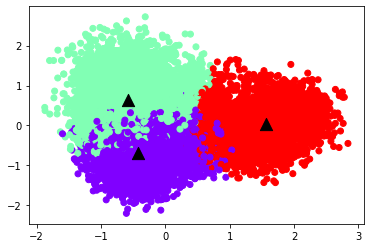

In [92]:
d2v_jobs_model = dbow_jobs_100


# define number of clusters here
kmeans_jobs_model = KMeans(n_clusters=3) 


X = kmeans_jobs_model.fit(d2v_jobs_model.docvecs.doctag_syn0)
labels=kmeans_jobs_model.labels_.tolist()


l = kmeans_jobs_model.fit_predict(d2v_jobs_model.docvecs.doctag_syn0)
pca = PCA(n_components=2).fit(d2v_jobs_model.docvecs.doctag_syn0)
datapoint = pca.transform(d2v_jobs_model.docvecs.doctag_syn0)

plt.figure
#label1 = ["#FFFF00", "#008000", "#0000FF", "#800080"]
#color = [label1[i] for i in labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=labels, cmap='rainbow')

centroids = kmeans_jobs_model.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
plt.show()

### KMeans for resumes

/Users/richardkuzma/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  import sys
/Users/richardkuzma/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  # This is added back by InteractiveShellApp.init_path()
/Users/richardkuzma/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  if sys.path[0] == '':
/Users/richardkuzma/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `doctag_syn0` (Attribute will be removed in 4.0.0, use docvecs.vectors_docs instead).
  del sys.path[0]


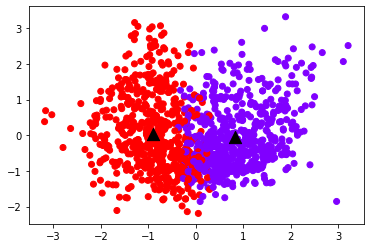

In [102]:
d2v_resume_model = dbow_res_100

# define number of clusters here
kmeans_resumes_model = KMeans(n_clusters=2) 


X = kmeans_resumes_model.fit(d2v_resume_model.docvecs.doctag_syn0)
labels=kmeans_resumes_model.labels_.tolist()


l = kmeans_resumes_model.fit_predict(d2v_resume_model.docvecs.doctag_syn0)
pca = PCA(n_components=2).fit(d2v_resume_model.docvecs.doctag_syn0)
resume_datapoint = pca.transform(d2v_resume_model.docvecs.doctag_syn0)

plt.figure
#label2 = ["#FFFF00", "#008000", "#0000FF", "#800080"]
#color = [label2[i] for i in labels]
plt.scatter(resume_datapoint[:, 0], resume_datapoint[:, 1], c=labels, cmap='rainbow')

resume_centroids = kmeans_resumes_model.cluster_centers_
resume_centroidpoint = pca.transform(resume_centroids)
plt.scatter(resume_centroidpoint[:, 0], resume_centroidpoint[:, 1], marker='^', s=150, c='#000000')
plt.show()